# Journey into NLP 2 - Sentiment Classification
### Haidar Khan - 3/14/2019

## Introduction
Welcome to the second article in this series on Natural Language Processing (NLP). As mentioned in the [first article](), the goal of this series is to develop an understanding of current approaches in NLP. In this article, we will discuss an approach to classifying text by the sentiment expressed in the text. The focus in this article will be understanding the problem setup and the code.

In the first article, we discussed how words are represented in modern NLP systems. We covered two approaches to learning word representations, called embeddings. In this article we will use the word embeddings to train a machine learning model to classify short segments of text based on the sentiment expressed by the writer. The material from the first article is not required to follow this article. The only aspect of word embeddings that is important for this article is that the embeddings give us a way to represent words as low-dimensional, dense vectors that preserve low level relationships between words.

## References
The original papers for each method will be referenced whenever possible. 

The material in this series will be based mostly on the excellent set of lectures from Stanford University - Natural Language Processing taught by Christopher Manning and Richard Socher ([available on Youtube](https://www.youtube.com/watch?v=OQQ-W_63UgQ&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6)) 

Code will also be referenced in each article. An excellent starting resource is [available here](https://github.com/lyeoni/nlp-tutorial).

### Text classification

The sentiment classification problem is a subtask of the general text classification problem. We will describe the general text classification setup here and note that the setup for sentiment classification is identical.

Text classification is an example of a supervised machine learning task. Supervised machine learning is when a model is shown examples that consist of two parts: the data and the label, and the model is asked to "learn" the relationship between the data and the labels during the training phase. When the model is deployed into the wild jungle that is the real world, the model is shown just the data and the expectation is that the label the model predicts corresponds to the true (and unknown) label. Thus, we see that there are two main phases for a machine learning model. In the training phase, the model updates its parameters to correctly match the data and labels of training examples. In the testing phase, the parameters of the model are fixed and the model simply outputs its best guess for the labels of the testing examples. For this type of setup, someone (usually many people) needs to exert many man-hours to correctly label the data.

In the context of text classification, the data comprises of a sequence of words and the label represents some interesting classification of the sentence. For example, the label for a text could be "declarative sentence" indicating that the text is a special type of sentence called a declarative sentence. Another type of text label could be related to the usefullness of the text to other users, such as the usefullness score of a product review. For sentiment classification, the label corresponds to the feeling expressed in the review usually "negative", "neutral", or "positive".

| Sentence ($\mathbf{x}$) | Class ($y$) |
| ----------------------------------------- | -------- |
| A masterpiece four years in the making. | positive |
| Offers a breath of the fresh air of true sophistication. | positive |
| Light, cute and forgettable | negative |
| Video games are more involving than this mess | negative |

We will denote the sequence of words in a text as $\mathbf{x}$ and the corresponding label as $y$. These pairs $(\mathbf{x},y)$ are compiled into a dataset of examples $\{(\mathbf{x},y)_i\}_{i=1}^N$, notice that $i$ here indexes examples not words in a text. Importantly, the sequence of words in each example are not guaranteed to be the same length. This presents a problem that prevents the straightforward application of standard supervised machine learning algorithms to text classification and motivates the use of a special class of models called *sequence models* (not considered here). The workaround we use in this article is much simpler and involves summarizing the text by a single vector.

### Representing text as a sequence of word embeddings

Since word embeddings are a good way to represent words, using them to represent each word in a text is also a good way to represent text. This is straightforward, each word in a text is replaced by its corresponding word embedding $w_1, w_2, ... w_n$. As a technical point, words not present in the vocabulary are replaced by the embedding for the "UNK" token. The sequence of word embeddings is then passed to a machine learning classifier (in our case, always a neural network). This transformation is standard in NLP as there are many (empirically observed) advantages to using word embeddings over one-hot encodings for words. 

One may wonder at this point where the word embeddings come from. We saw in the first article of this series that word embeddings can be trained in an unsupervised (no labels needed) fashion on a corpus. We could do the same on our dataset of examples $\{(\mathbf{x},y)_i\}_{i=1}^N$ by training the word embeddings on the data $\mathbf{x}$ and ignoring the labels $y$. However, this is not a good idea because we know from experience that learning good word embeddings requires a large dataset, usually millions of words long. Instead, we will leverage the concept of "unsupervised pretraining" by using word embeddings (pre)trained on a large corpus. Fortunately, there are many publically available pretrained word embeddings such as [word2vec](https://code.google.com/archive/p/word2vec/), [GloVe](https://github.com/stanfordnlp/GloVe), or [ELMO](https://allennlp.org/elmo). It is also possible to finetune a pretrained embedding for a specific task, but this is usually not a good idea unless the dataset for the task is large.

![Example sentence embedding](./images/sent_embed1.png)

In this figure, we can see a sentence represented as a sequence of word vectors. As mentioned before, all the sentences in a dataset may not be the same length, posing a problem for simple machine learing algorithms that require fixed size inputs. One simple way to deal with this issue is called the "bag of words". As shown in the figure, under the bag of words modeling assumption, the words in a sentence can be combined (by averaging or addition) into a single vector. This assumption ignores the order of the words in the sentence as there is no way to preserve the order of the words after they are thrown into the bag.

<img src="./images/bag_of_words.jpg" style="height: 200px;">
<center>A bag of words art display at Carnegie Mellon University.</center>

### Simple model setup

As is standard in machine learning, we define a function $f(x;\theta)$ (with input $x$ and parameters $\theta$) that correctly matches input data $x$ with the labels $y$ of our dataset. In this case, the function $f(\cdot;\theta)$ is defined as a feedforward neural network, also known as multi-layer perceptron (MLP), that accepts as input a column vector $x \in \mathbb{R}^{d \times 1}$ and produces as output a probability distribtion over predicted labels $p \in \mathbb{R}^{C \times 1}$ (note that for C classes, $p$ is a vector that satisfies the conditions of a probability distribution, ie. (i) $\sum_{c=1}^C{p_c} = 1$ and (ii) $p_c \geq 0$ $\forall c=1,2...C$).

We will show how this is done for a neural network with two hidden layers of size $k_1$ and $k_2$. This network has three weight matrices which we will call $W^1, W^2,$ and $W^3$ and a [pointwise nonlinear activation function](https://en.wikipedia.org/wiki/Activation_function) $\sigma(\cdot) = ReLU(\cdot)$. The first hidden layer $h^1$ is directly a function of the input $x$ and is defined as:
$$ h^1 = \sigma(W^1 x) $$
Since $h^1$ is defined as a $k_1$-dimensional column vector, this means that $W^1$ is a $k_1 \times d$ matrix. The second hidden layer $h^2$ is a function of the first hidden layer and defined as:
$$ h^2 = \sigma(W^2 h^1) $$
Since $h^2$ is defined as a $k_2$-dimensional column vector, this means that $W^2$ is a $k_2 \times k_1$ matrix. The output vector $p$ is defined as:
$$ p = softmax(W^3 h^2) $$
Thus, $W^3$ is a $ C \times k_2$ matrix and $softmax(\cdot)$ is a function that converts any vector into a probability distribution ([read about softmax here](https://en.wikipedia.org/wiki/Softmax_function)). We introduce the variables $h^1$ and $h^2$ for clarity, the entire neural network can be written as:
$$ f(x;\theta) := softmax(W^3 \sigma(W^2 \sigma(W^1 x))) $$
Where the parameters of the neural network are entirely summarized as $\theta = \{W^1, W^2, W^3 \}$. Note that for notational simplicity we are ignoring bias terms that are used in practice. The illustration below shows the diagram of this neural network.

<img src="./images/neural_network1.png" style="height:300px;">

We want to find the settings of our model parameters $\theta$ that minimizes the models error in predicting the labels of the dataset with the expectation that such a parameter setting will be useful for data the model has never seen before (generalization). There exist many possible choices of error/loss functions we can choose to minimize, such as mean squared error or hinge loss. Let us focus on one particular error function called cross entropy error (CEE). CEE measures the distance between the probability vector associated with a true label $y$ (the one hot vector $t$) and the probability vector over labels outputted from the model ($p$ from above). The two vectors $t$ and $p$ are both $C \times 1$ column vectors and satisfy both the properties of a probability distribution. CEE is defined as:
$$ CEE(y,p) = -\sum_{c=1}^C{t_c \log{p_c}} $$

By observing that $t$ is a one hot vector where $t_{y} = 1$ and zero everywhere else if $y$ is the true label, we can rewrite CEE as:
$$ CEE(y,p) = -\log{p_{y}} $$

Now that we have defined a loss function and since we were careful to define the model with only differentiable operations, we can solve the following minimization problem on a dataset of labeled examples $\{(x,y)_i\}_{i=1}^N$ using gradient descent:
$$ \min_\theta{ \frac{1}{N} \sum_{i=1}^N{CEE(y_i, f(x_i;\theta)} } $$

Before building our model we need to deal with converting a sequence of words into a fixed size input to our neural network. For the purposes of this demonstration, we will do this by combining the word embeddings for each text ($\mathbf{x}$) into a single vector. The input to the neural network $x$ is then formed from the sequence of word embeddings $w_1, w_2, ... w_n$ as:
$$ x = \frac{1}{n}\sum_{j=1}^n{w_j} $$
Note that $x$ is the same size as a word embedding vector ($d \times 1$) and is expected to summarize the text. Also note that the averaging operation loses all the word ordering information. 

## Practical Section

In this section we will demonstrate how to code the simple model described above in Tensorflow and train it on a dataset for sentiment classification.

The dataset we will be using for this demonstration is called the Stanford Sentiment Treebank (SST). We will use some utility functions written for SST provided as part of the [Stanford CS224D NLP course](https://cs224d.stanford.edu/syllabus.html), particularly code related to Question 4 from problem set 1. The required (and edited) [code]() is provided with this article.

### Loading the data

The `StanfordSentiment` class gives us some utility functions to load the Stanford Sentiment Treebank dataset
- `dataset.tokens()` - tokenizes the entire dataset
- `dataset.getTrainSentences()` - returns a list of `(sentence, sentiment_label)` pairs in the training set
- `dataset.getDevSentences()` - returns a list of `(sentence, sentiment_label)` pairs in the development set
- `dataset.getTestSentences()` - returns a list of `(sentence, sentiment_label)` pairs in the test set

The `sentence` in an example is a list of words (all lowercase). The `sentiment_label` in an example is the level of sentiment expressed in a sentence. There are five disjoint levels of sentiment: {very negative, negative, neutral, positive, very positive} encoded as {0,1,2,3,4}.

Notice that there are three distinct datasets for a machine learning problem: training set, development set, and test set.
- The training set is used to learn the parameters of the neural network using gradient descent
- The development set is used to optimize hyperparameters (units in hidden layers, regularization, learning rate).
- The test set is used to evaluate the model's performance
   

In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
from matplotlib import pyplot as plt
from code_utils.data_utils import StanfordSentiment
from random import shuffle

#GPU session config
sess_config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

# Load the dataset
dataset = StanfordSentiment('./data/stanfordSentimentTreebank')
tokens = dataset.tokens()
print('Number of tokens',len(tokens))

# Load the train set
trainset = dataset.getTrainSentences()
print('Label: %d - Sentence: %s' % (trainset[0][1], ' '.join(trainset[0][0])))

# Load the dev set
devset = dataset.getDevSentences()
print('Label: %d - Sentence: %s' % (devset[10][1], ' '.join(devset[10][0])))

Number of tokens 19539
Label: 3 - Sentence: the rock is destined to be the 21st century 's new `` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
Label: 4 - Sentence: unlike the speedy wham-bam effect of most hollywood offerings , character development -- and more importantly , character empathy -- is at the heart of italian for beginners .


### Load pretrained GLoVe embeddings

As input to our model, we will use pretrained word embeddings called [Global Vectors (GloVe)](https://nlp.stanford.edu/projects/glove/) as input word representations to our model. GloVe embeddings are similar to the word2vec embeddings discussed in a previous [article](). The GloVe embeddings are trained in a slightly different way. Instead of maximizing the dot product of words that appear in the same context, GloVe attempts to learn embedding vectors such that the dot product of two words equals the logarithm of their **co-occurence** probability.

The co-occurence probability represents how likely two words are to appear next to each other in natural language. This probability is calculated from a co-occurence matrix $C$, a $V \times V$ ($V$ is the size of the vocabulary) matrix that counts the number of times two words appear next to each other in a natural language corpus. Specifically, each element $C_{ij}$ stores the number of times word $i$ co-occurs with word $j$. Once this matrix is computed, each count can be converted to a probability by dividing the count value by the total number of times the word appears in the corpus.

The main idea behind matching dot products to the logarithms of co-ocurrence probabilities is that the co-occurence probabilities, or more specifically, the ratios of co-occurence probabilities encode some form of real meaning. If this is true, than the distance between vectors learned by GloVe embeddings represents the ratio of co-occurence probabilities, and by extension, encodes the real meanings of words. More details about the method for training word embeddings can be found in the [paper](https://nlp.stanford.edu/pubs/glove.pdf)

Fortunately, the developers of GloVe embeddings have shared the pretrained embeddings trained on large corpuses. In this experiment, we will use 50-dimensional GloVe embeddings trained on a 6 billion token corpus (Wikipedia+Gigaword) with a 400,000 word vocabulary available [here](http://nlp.stanford.edu/data/glove.6B.zip). 

We will use the 50,000 most common words in the vocabulary for our sentiment classification experiment and replace words not in the vocabulary with the special "UNK" token. Also, we will introduce a specially "PAD" token with a 50-dimensional zero embedding vector in order to pad the sentences in the texts to the same length. This is a practical requirement for feeding the inputs to the model. 

Lastly, we create two python dicts (`word2id` and `id2word`) to make converting between words and word ids easily. Note that word ids are arbitrary, in the code we assign lower ids to more common words.

In [2]:
# I have it saved in ./data/glove.6B.50d.txt
embed_file = './data/glove.6B.50d.txt'
vocab_size = 50000 # up to 400k
embed_dim = 50

embedding_mat = np.zeros((vocab_size,embed_dim), dtype=np.float32)
word2id = {'PAD': 0,'UNK': 1}
id2word = {0: 'PAD', 1: 'UNK'}

# make UNK embedding a random vector
embedding_mat[1,:] = np.random.rand((embed_dim))
# get the rest of the embeddings we want from the file, we will get the "vocab_size" most common words.
with open(embed_file,'r') as efile:
    for index,line in enumerate(efile.readlines()):
        splitted = line.split()
        word2id[splitted[0]] = index+2
        id2word[index+2] = splitted[0]
        embedding_mat[index+2] = np.asarray(splitted[1:])
        if index+2 == vocab_size-1: break

#print a few random word and the norm of its embedding vector
for _ in range(5):
    r = np.random.randint(0,vocab_size)
    print('Word: %s | ID: %d | Embedding Norm: %f' %(id2word[r], word2id[id2word[r]], np.linalg.norm(embedding_mat[r,:])))

Word: profitability | ID: 10839 | Embedding Norm: 5.302562
Word: rogers | ID: 5640 | Embedding Norm: 3.613782
Word: 920 | ID: 37801 | Embedding Norm: 4.058931
Word: 0-5 | ID: 38299 | Embedding Norm: 4.706855
Word: scribes | ID: 45848 | Embedding Norm: 3.706744


### Helper and batching functions

Three functions are defined for loading data:
- `word_lookup` - Looks up the id of a word in the `word2id` dictionary, if the word is not found (not in our vocabulary) then returns the id for "UNK".
- `zero_pad` - Accepts as input a list of lists of word ids representing a batch of sentences. Uses zero padding to make all sentences in the batch the same length (`max_len`).
- `get_batch` - Returns a list of size `batch_size` pairs-`(data,label)` from a given `dataset` and index in the dataset (`data_ind`). For training, it assumes the dataset is a list of example pairs that has already been shuffled (this is important for training neural networks). This function zero pads the sentences so that all sentences in the batch are the same length.

In [6]:
def word_lookup(word, word2id):
    if word in word2id:
        return word2id[word]
    else:
        return 1

def zero_pad(sent_batch):
    max_len = max([len(sent) for sent in sent_batch])
    for sent in sent_batch:
        sent.extend((max_len-len(sent))*[0])
    return sent_batch

def get_batch(dset, data_ind, batch_size):
    nExamples = len(dset)
    data = list()
    labels = list()
    if data_ind+batch_size <= nExamples:
        indices = range(data_ind,data_ind+batch_size)
    else: # roll over
        indices = list(range(data_ind,nExamples))
        indices.extend(list(range(batch_size-len(indices))))
    for ind in indices:
        sent, label = dset[ind]
        data.append([word_lookup(word, word2id) for word in sent])
        labels.append(label)
    return zero_pad(data),labels

# print an example batch
ex_batch, labels = get_batch(trainset, len(trainset)-10, 5)
for ex in ex_batch:
    print(len(ex), ex)

26 [1898, 1193, 21, 9, 1, 61, 2713, 7, 6745, 3, 36, 2, 93, 875, 83, 771, 6745, 16, 16305, 2, 1223, 5, 2997, 133, 22, 4]
26 [436, 9, 1, 36172, 22627, 19, 9, 3257, 5, 281, 10165, 5856, 6510, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
26 [36, 1, 11, 35214, 39681, 909, 22, 1916, 1905, 380, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
26 [2, 1007, 11, 2221, 16, 593, 3464, 1, 7, 1, 3, 1782, 361, 17696, 57, 48, 89, 248, 1517, 49, 2516, 6, 8516, 9, 7301, 4]
26 [262, 9, 221, 666, 5, 5048, 9, 81, 7, 243, 3, 7, 5, 2823, 9, 12318, 1397, 11, 525, 4, 0, 0, 0, 0, 0, 0]


### Building the neural network for sentiment classification

In the following section, we will show how to create the tensorflow graph for the simple two layer neural network described above. We define a function `build_model` that creates a tensorflow graph representing the model and returns the graph and the tensorflow operations (ops) we are interested in. `build_model` accepts the following input:
- `l1_hidden_units` - number of hidden units in the first hidden layer of the network.
- `l1_hidden_units` - number of hidden units in the second hidden layer of the network.
- `num_classes` - number of possible classes. This defines the size of the output softmax layer of the network. In our case, this is 5.
- `reg_val` - regularization parameter for L2 regularization. L2 regularization is a method to constrain the weights of a neural network for better generalization. We will optimize this as value as a hyperparameter.
- `learning_rate` - Learning rate of the SGD optimizer. We will fix this at 0.3, but changing it can improve performance significantly. Try playing with this value.

Here is a more detailed breakdown of the code:
- Section 1: Placeholders are defined for the input sentences and labels in a batch. The `None` in the shape argument allows different size tensors (such as different batch sizes or sentence lengths) across `run` calls on the graph. The `class_labels` placeholder is a vector of size `batch_size` sentiment labels (0,1,2,3,4). `labels` converts `class_labels` to a matrix of one-hot vectors of size `batch_size,num_classes`. The `inputs` placeholder is a matrix of word ids of size `batch_size,max_len` where `max_len` is the length of the largest sentence in the batch.
- Section 2: Computes the 50-dimensional sentence embedding for each sentence in the batch. `tf.nn.embedding_lookup` looks up the word embeddings in the pretrained GloVe `embedding` matrix by the word ids. Then we average the word embeddings in a sentence to get the `sent_embed`. Notice that we are using `tf.count_nonzero` and `tf.reduce_sum` to implement our own average instead of using `tf.reduce_mean` as we need to account for (ignore) the padding vectors. Also note that the `trainable=False` argument is used to make sure we don't modify the pretrained embeddings during training.
- Section 3: We define the weights and biases of the first hidden layer with L2 regularization and define the output of the hidden layer as `l1_hidden` with a ReLU activation function.
- Section 4: We define the weights and biases of the second hidden layer with L2 regularization and define the output of the hidden layer as `l2_hidden` with a ReLU activation function.
- Section 5: The weights of the softmax layer are defined and the `logits` and output probabilities are separtately defined.
- Section 6: The loss function consists of the cross-entropy loss between the true labels and predictions and the regularization penalty applied to the weights. The accuracy and SGD optimizer are also defined here.

We end this section with a quick sanity check on the shapes of intermediate layers and the output.

In [7]:
def build_model(l1_hidden_units, l2_hidden_units, num_classes=5, reg_val=1e-4, learning_rate=0.3):
    graph = tf.Graph()
    with graph.as_default():
        # Section 1: Input data placeholders
        with tf.name_scope('inputs'):
            inputs = tf.placeholder(tf.int32, shape=[None, None]) # batch x sentence length placeholder of embeddings
            class_labels = tf.placeholder(tf.int32, shape=[None]) # batch placeholder of sentiment labels
            labels = tf.one_hot(indices=class_labels, depth=num_classes, axis=-1)
        # Section 2: Sentence embeddings
        with tf.name_scope('sentence_embedding'):
            embeddings = tf.get_variable("glove_embeddings", initializer=embedding_mat, trainable=False)
            word_embeds = tf.nn.embedding_lookup(embeddings, inputs)
            word_counts = tf.count_nonzero(word_embeds, axis=1)
            sent_embed = tf.reduce_sum(word_embeds, axis=1)/tf.cast(word_counts, dtype=tf.float32)

        # Section 3: Layer 1 weights and hidden units
        with tf.name_scope('layer1'):
            l1_weights = tf.get_variable("l1_weights", shape=[embed_dim, l1_hidden_units], 
                                         regularizer=tf.contrib.layers.l2_regularizer(reg_val))
            l1_biases = tf.get_variable("l1_biases", shape=[l1_hidden_units],
                                       regularizer=tf.contrib.layers.l2_regularizer(reg_val))    
            l1_hidden = tf.nn.relu(tf.nn.bias_add(tf.matmul(sent_embed, l1_weights), l1_biases))
        # Section 4: Layer 2 weights and hidden units
        with tf.name_scope('layer2'):
            l2_weights = tf.get_variable("l2_weights", shape=[l1_hidden_units, l2_hidden_units],
                                        regularizer=tf.contrib.layers.l2_regularizer(reg_val))
            l2_biases = tf.get_variable("l2_biases", shape=[l2_hidden_units],
                                       regularizer=tf.contrib.layers.l2_regularizer(reg_val))
            l2_hidden = tf.nn.relu(tf.nn.bias_add(tf.matmul(l1_hidden, l2_weights), l2_biases))
        # Section 5: Output layer
        with tf.name_scope('output_layer'):
            out_weights = tf.get_variable("out_weights", shape=[l2_hidden_units,num_classes],
                                         regularizer=tf.contrib.layers.l2_regularizer(reg_val))
            logits = tf.matmul(l2_hidden, out_weights)
            probs = tf.nn.softmax(logits)
        # Section 6: Loss function and optimizer            
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        loss += tf.losses.get_regularization_loss()
        acc, acc_op = tf.metrics.accuracy(class_labels, tf.argmax(logits, axis=-1))
        with tf.name_scope('optimizer'):
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)        
        
        
    return graph, inputs, class_labels, loss, optimizer, acc_op, embeddings, sent_embed, l1_hidden, l2_hidden, probs
# check that the model is correctly defined
graph, inputs, class_labels, loss, optimizer, acc_op, embeddings, sent_embed, l1_hidden, l2_hidden, probs = build_model(500, 250, 5, 0.001, 0.5)
with tf.Session(graph=graph, config=sess_config) as session:
    sents, batch_labels = get_batch(trainset, 0, batch_size=128)
    # We must initialize all variables before we use them.
    tf.local_variables_initializer().run()
    tf.global_variables_initializer().run()
    print('Variables initialized') 
    print('Batch size:', len(sents))
    print('Embedding matrix shape:',embeddings.eval().shape)    
    print('Sentence embedding shape:', sent_embed.eval(feed_dict={inputs: sents}).shape)
    print('Hidden layer 1 shape:', l1_hidden.eval(feed_dict={inputs: sents}).shape)
    print('Hidden layer 2 shape:', l2_hidden.eval(feed_dict={inputs: sents}).shape)
    print('Output prob shape:', probs.eval(feed_dict={inputs: sents}).shape)
    print('Loss value:', loss.eval(feed_dict={inputs: sents, class_labels: batch_labels}))
    print('Acc value:', acc_op.eval(feed_dict={inputs: sents, class_labels: batch_labels}))

Variables initialized
Batch size: 128
Embedding matrix shape: (50000, 50)
Sentence embedding shape: (128, 50)
Hidden layer 1 shape: (128, 500)
Hidden layer 2 shape: (128, 250)
Output prob shape: (128, 5)
Loss value: 1.8277633
Acc value: 0.234375


### Train the network and optimize regularization hyperparameter

In this section, we train the parameters (weights and biases) of the network on the training dataset and attempt to optimize the regularization (hyper) parameter on the development set by trying different settings in a grid search. There are many other hyperparameters that can be optimized, such as hidden layer sizes, batch size, learning rate, regularization type, and initialization types, but we will not carry that out here. As an aside, an alternative to grid search is randomly trying different parameters as proposed by this [paper](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) by Bergestra and Bengio.

In the next code block, we visualize the results of the hyperparameter tuning.

The code below has two loops: the outer loop iterates over different hyperparameter settings and the inner loop trains the model for `num_steps` iterations. We initialize a new model in each iteration of the outer loop, train it for `num_steps` iterations, and save the results

In [8]:
num_steps = 60001
batch_size = 128
verbose = True

def evaluate_model(dset, session, loss_op, acc_op):
    batch_inputs, batch_labels = get_batch(dset, 0, len(dset))
    feed_dict = {inputs: batch_inputs, class_labels: batch_labels}
    loss, acc = session.run([loss_op, acc_op], feed_dict=feed_dict)
    return loss, acc

param_list = [(500,250,0.000001), (500,250,0.00001), (500,250,0.00003), (500,250,0.00005), (500,250,0.00008), (500,250,0.0001)]
results = list()

for h1_size, h2_size, reg in param_list:
    print('(+) Training with parameters: h1_size %d | h2_size %d | reg %f' % (h1_size, h2_size, reg))
    print('-'.join(50*['-']))
    shuffle(trainset)
    graph, inputs, class_labels, loss, optimizer, acc, embeddings, sent_embed, l1_hidden, l2_hidden, probs = build_model(h1_size, h2_size, num_classes=5, reg_val=reg)
    model_path = 'models/model_%d_%d_%f.ckpt' % (h1_size, h2_size, reg)
    with graph.as_default():
        saver = tf.train.Saver() # saves model parameters
    with tf.Session(graph=graph, config=sess_config) as session:
        tf.local_variables_initializer().run()
        tf.global_variables_initializer().run()
        average_loss = 0
        average_acc = 0
        history = []
        data_index = 0
        for step in range(num_steps):
            batch_inputs, batch_labels = get_batch(trainset, data_index, batch_size)
            feed_dict = {inputs: batch_inputs, class_labels: batch_labels}
            _, loss_val, acc_val = session.run([optimizer, loss, acc], feed_dict=feed_dict)
            
            average_loss += loss_val
            average_acc += acc_val
            if step % 5000 == 0 and verbose:
                if step > 0:
                    average_loss /= 5000
                    average_acc /= 5000
                # calculate loss on subset of development set
                shuffle(devset)
                dev_loss, dev_acc = evaluate_model(devset[0:len(devset)//5], session, loss, acc)
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Step %10d: Avg train loss: %f | Avg train acc: %f | Dev loss: %f | Dev acc: %f' 
                      % (step, average_loss, average_acc, dev_loss, dev_acc))
                history.append({'train_loss': average_loss, 'train_acc': average_acc, 'dev_loss': dev_loss, 'dev_acc': dev_acc})
                average_loss = 0
                average_acc = 0

            data_index += batch_size
            if data_index >= len(trainset):
                data_index = 0
                shuffle(trainset)
        
        # after we are done training, evaluate train and dev accuracy and save model parameters
        save_path = saver.save(session, model_path)
        train_loss, train_acc = evaluate_model(trainset, session, loss, acc)
        dev_loss, dev_acc = evaluate_model(devset, session, loss, acc)
        results.append({'h1_size': h1_size,
                       'h2_size': h2_size,
                       'reg': reg,
                       'train_loss': train_loss,
                        'train_acc': train_acc,
                       'dev_loss': dev_loss,
                       'dev_acc': dev_acc,
                       'history': history,
                       'save_path': save_path})     

(+) Training with parameters: h1_size 500 | h2_size 250 | reg 0.000001
---------------------------------------------------------------------------------------------------
Step          0: Avg train loss: 1.598886 | Avg train acc: 0.250000 | Dev loss: 1.563836 | Dev acc: 0.264368
Step       5000: Avg train loss: 1.369981 | Avg train acc: 0.372775 | Dev loss: 1.463804 | Dev acc: 0.404808
Step      10000: Avg train loss: 1.094850 | Avg train acc: 0.437401 | Dev loss: 1.808279 | Dev acc: 0.476459
Step      15000: Avg train loss: 0.601781 | Avg train acc: 0.525529 | Dev loss: 3.086536 | Dev acc: 0.576440
Step      20000: Avg train loss: 0.528516 | Avg train acc: 0.610546 | Dev loss: 2.861547 | Dev acc: 0.637204
Step      25000: Avg train loss: 0.460465 | Avg train acc: 0.658549 | Dev loss: 3.110251 | Dev acc: 0.678095
Step      30000: Avg train loss: 0.050673 | Avg train acc: 0.705702 | Dev loss: 5.394896 | Dev acc: 0.730749
Step      35000: Avg train loss: 0.017336 | Avg train acc: 0.75087

Step       5000: Avg train loss: 1.404243 | Avg train acc: 0.371592 | Dev loss: 1.507652 | Dev acc: 0.400644
Step      10000: Avg train loss: 1.212410 | Avg train acc: 0.426755 | Dev loss: 1.785128 | Dev acc: 0.457346
Step      15000: Avg train loss: 0.879291 | Avg train acc: 0.497350 | Dev loss: 2.386524 | Dev acc: 0.540336
Step      20000: Avg train loss: 0.615910 | Avg train acc: 0.583054 | Dev loss: 2.913209 | Dev acc: 0.621168
Step      25000: Avg train loss: 0.355122 | Avg train acc: 0.657845 | Dev loss: 3.379833 | Dev acc: 0.692378
Step      30000: Avg train loss: 1.377558 | Avg train acc: 0.686990 | Dev loss: 2.920263 | Dev acc: 0.684048
Step      35000: Avg train loss: 0.931830 | Avg train acc: 0.693164 | Dev loss: 3.275627 | Dev acc: 0.703110
Step      40000: Avg train loss: 1.204760 | Avg train acc: 0.704407 | Dev loss: 2.987030 | Dev acc: 0.705372
Step      45000: Avg train loss: 0.838541 | Avg train acc: 0.714560 | Dev loss: 3.529988 | Dev acc: 0.723223
Step      50000: Av

---- RESULTS SUMMARY ---
*h1_size : 500.000000 | h2_size : 250.000000 | reg : 0.000001 | train_loss : 0.009266 | train_acc : 0.864753 | dev_loss : 5.854029 | dev_acc : 0.864676 | 
 h1_size : 500.000000 | h2_size : 250.000000 | reg : 0.000010 | train_loss : 0.068493 | train_acc : 0.831744 | dev_loss : 5.503753 | dev_acc : 0.831672 | 
 h1_size : 500.000000 | h2_size : 250.000000 | reg : 0.000030 | train_loss : 0.114955 | train_acc : 0.863151 | dev_loss : 4.288242 | dev_acc : 0.863072 | 
 h1_size : 500.000000 | h2_size : 250.000000 | reg : 0.000050 | train_loss : 0.213827 | train_acc : 0.826868 | dev_loss : 4.170769 | dev_acc : 0.826796 | 
 h1_size : 500.000000 | h2_size : 250.000000 | reg : 0.000080 | train_loss : 0.619775 | train_acc : 0.768621 | dev_loss : 3.463444 | dev_acc : 0.768559 | 
 h1_size : 500.000000 | h2_size : 250.000000 | reg : 0.000100 | train_loss : 0.599380 | train_acc : 0.744619 | dev_loss : 3.631648 | dev_acc : 0.744557 | 


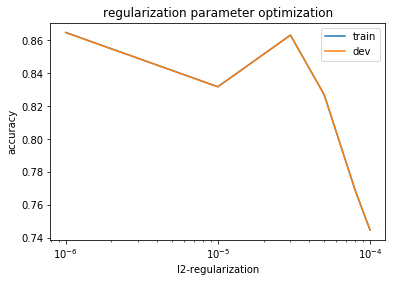

In [9]:
reg_param = [res['reg'] for res in results]
dev_acc = [res['dev_acc'] for res in results]
train_acc = [res['train_acc'] for res in results]

best_index = int(np.argmax(dev_acc))

# print summary of results
print('---- RESULTS SUMMARY ---')
for i,res in enumerate(results):
    res_str = ' '
    if i == best_index: res_str='*'
    for key, val in res.items():
        if key in ['history', 'save_path']: continue
        res_str+='%s : %f | ' % (key, val)
    print(res_str)    



plt.figure()
plt.semilogx(reg_param, train_acc, label='train')
plt.semilogx(reg_param, dev_acc, label='dev')
plt.xlabel('l2-regularization')
plt.ylabel('accuracy')
plt.title('regularization parameter optimization')
plt.legend()
plt.show()

### Results Summary

We can clearly see that setting for the regularization parameter that is the best choice for this network. Clearly we can fine tune this and other hyperparameter values further, but even this simple tuning step results in about ~80% accuracy on the development set. The next step would be to select the best hyperparameter values and then evaluate the performance of the model on the test set.

In [10]:
best_model = results[best_index]['save_path']
# rebuild the model
graph, inputs, class_labels, loss, optimizer, acc, embeddings, sent_embed, l1_hidden, l2_hidden, probs = build_model(results[best_index]['h1_size'],
                                                                                                                     results[best_index]['h2_size'],
                                                                                                                     num_classes=5, 
                                                                                                                   reg_val=results[best_index]['reg'])
with graph.as_default():
    saver = tf.train.Saver() # saves model parameters
# load the test set
testset = dataset.getTestSentences()

with tf.Session(graph=graph, config=sess_config) as session:
    # Restore variables from disk.
    saver.restore(session, best_model)
    session.run(tf.local_variables_initializer())
    print("Model restored. Evaluating performance on test data:")
    test_loss, test_acc = evaluate_model(testset, session, loss, acc)
    print("Best Model: Test loss=%f | Test accuracy=%f" % (test_loss, test_acc))

INFO:tensorflow:Restoring parameters from models/model_500_250_0.000001.ckpt
Model restored. Evaluating performance on test data:
Best Model: Test loss=6.134393 | Test accuracy=0.312217


## Conclusion

In this article we learned how to set up a simple text classification problem, specifically sentiment classification, for a machine learning model. We leveraged pretrained word embeddings to encode the words in a sentence and constructed very simple sentence embeddings by averaging word embeddings. The sentence embeddings were used as input to a two layer, regularized neural network that could predict the sentiment expressed in a sentence as one of five sentiment levels. We acheived around 82% accuracy on the development set using this simple model. 

Aside from further optimizing hyperparameters, we can improve our model by coming up with a better solution to creating sentence embeddings. Averaging word embeddings is a simple way to create a fixed size representation for our model, but notice that all word ordering and context information is lost after averaging. One way to preserve these kinds of properties is using a **sequence model** that can create a fixed size representation for a sentence and encode word order. We will discuss one family of sequence models called Recurrent Neural Networks in the next article.